# Hotel Ranking Model Development
This notebook demonstrates the process of building a hotel ranking model using a synthetic dataset. We will:
1. Generate the dataset.
2. Preprocess the data.
3. Perform feature engineering.
4. Train the model using a Gradient Boosting Regressor.
5. Evaluate the model's performance.


In [1]:
import sys
import os

# Move one level up from 'notebooks' to the root directory, then point to 'src'
src_path = os.path.abspath('../src')

# Ensure the 'src' directory is added to the Python path
if src_path not in sys.path:
    sys.path.append(src_path)

# Print sys.path to verify that the path is correctly added
print("Current sys.path:")
print(src_path)


Current sys.path:
/Users/santiago/Documents/repos/resortpass-hotel-ranking/src


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from data_preprocessing import load_data, preprocess_data
from feature_engineering import feature_engineering
from model import train_model, evaluate_model
from hyperparameter_tuning import tune_hyperparameters
from evaluate import visualize_top_10_hotels
from sklearn.model_selection import train_test_split

In [3]:
# Step 1: Load and preprocess the data
df = load_data()
df = preprocess_data(df)
df.head()

,Hotel_ID,Price,Category,Location_Proximity,Review_Score,Amenities,Search_Count,CTR,Bookings,Time_Spent,Review_Text
0,H0001,304,Luxury,2.352654,2.115185,"[1, 0, 1, 0, 0]",485,0.067737,9,54.350891,Hotel 1 is a great choice for your stay. Comfo...
1,H0002,211,Economy,5.579619,2.934708,"[1, 0, 1, 0, 1]",51,0.053647,119,284.830054,Hotel 2 is a great choice for your stay. Excel...
2,H0003,475,Budget,4.397519,3.222133,"[0, 0, 1, 1, 1]",506,0.115848,191,62.421985,Hotel 3 is a great choice for your stay. Decen...
3,H0004,315,Luxury,5.626492,2.402837,"[1, 1, 1, 1, 1]",122,0.067878,77,55.027526,Hotel 4 is a great choice for your stay. Comfo...
4,H0005,489,Luxury,10.919837,4.089602,"[1, 0, 0, 0, 0]",955,0.208035,126,242.208985,Hotel 5 is a great choice for your stay. Excel...


In [4]:
df.columns

Index(['Hotel_ID', 'Price', 'Category', 'Location_Proximity', 'Review_Score',
       'Amenities', 'Search_Count', 'CTR', 'Bookings', 'Time_Spent',
       'Review_Text'],
      dtype='object')

In [5]:
# Step 2: Feature Engineering
df = feature_engineering(df)
df.head()

,Hotel_ID,Price,Location_Proximity,Review_Score,Search_Count,CTR,Bookings,Time_Spent,text_feature_1,text_feature_2,...,text_feature_49,text_feature_50,Category_Economy,Category_Luxury,Price_Location_Interaction,amenity_1,amenity_2,amenity_3,amenity_4,amenity_5
0,H0001,0.028222,-1.432160,2.115185,485,0.067737,9,-1.388816,0.788542,-0.158693,...,0.000019,0.000030,False,True,715.206671,1,0,1,0,0
1,H0002,-0.754544,-0.858959,2.934708,51,0.053647,119,1.535939,0.790432,-0.254716,...,-0.000078,-0.000017,True,False,1177.299714,1,0,1,0,1
2,H0003,1.467500,-1.068934,3.222133,506,0.115848,191,-1.286395,0.807647,0.586552,...,-0.000056,0.000064,False,False,2088.821466,0,0,1,1,1
3,H0004,0.120807,-0.850634,2.402837,122,0.067878,77,-1.380230,0.788542,-0.158693,...,0.000019,0.000030,False,True,1772.344978,1,1,1,1,1
4,H0005,1.585336,0.089615,4.089602,955,0.208035,126,0.995083,0.790432,-0.254716,...,-0.000078,-0.000017,False,True,5339.800390,1,0,0,0,0


In [6]:
# Step 3: Define Features and Target + Train-Test Split
X = df.drop(columns=['Hotel_ID', 'Bookings'])
y = df['Bookings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 64), (200, 64), (800,), (200,))

In [8]:
# Step 4: Train the model
model = train_model(X_train, y_train)

In [9]:
model

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


In [10]:
# Step 5: Evaluate the model
mse, y_pred = evaluate_model(model, X_test, y_test)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 8423.242872576193


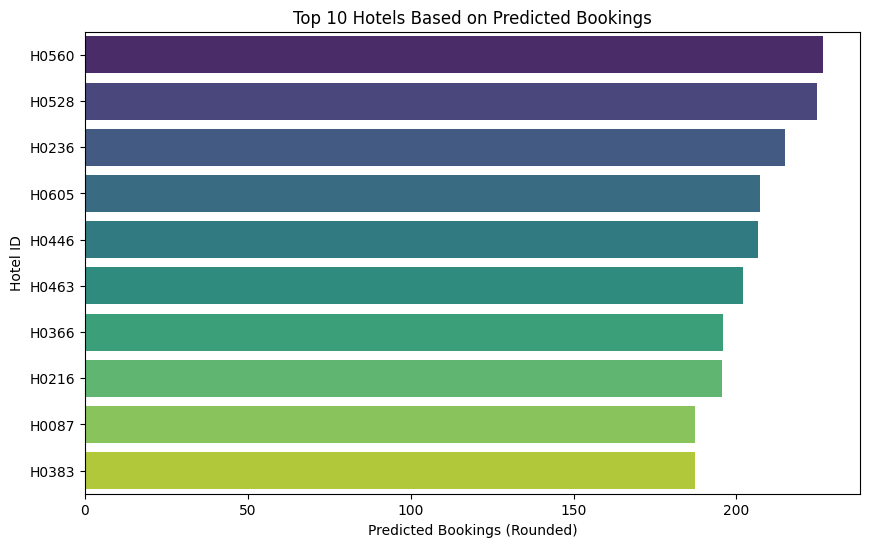

In [11]:
# Step 6: Visualize top 10 hotels based on predicted bookings
predictions = pd.DataFrame({'Hotel_ID': df['Hotel_ID'].iloc[X_test.index], 'Predicted_Bookings': y_pred})
visualize_top_10_hotels(predictions)


In [12]:
predictions.head()

,Hotel_ID,Predicted_Bookings
521,H0522,143.823970
737,H0738,140.521284
740,H0741,111.967315
660,H0661,122.068499
411,H0412,156.975677


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Define the parameter grid for tuning the hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages
    'learning_rate': [0.05, 0.1, 0.2],  # Shrinks the contribution of each tree
    'max_depth': [3, 5, 7],  # Maximum depth of the individual trees
    'subsample': [0.8, 0.9, 1.0]  # Fraction of samples to fit each base learner
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all CPUs
    verbose=2  # Show progress during fitting
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters found: {best_params}")

# Get the best model from grid search
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.2s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.2s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.1

In [14]:
# Predict with the best model on the test set
y_pred_best = best_model.predict(X_test)

# Calculate Mean Squared Error (MSE) for the best model
mse_best = mean_squared_error(y_test, y_pred_best)
print(f"Mean Squared Error (MSE) after hyperparameter tuning: {mse_best}")

# Post-process the predictions to ensure no negative values
y_pred_best = np.clip(y_pred_best, 0, None)  # Clip negative values to zero
y_pred_best = np.round(y_pred_best).astype(int)  # Round to integers


Mean Squared Error (MSE) after hyperparameter tuning: 7450.92237396022


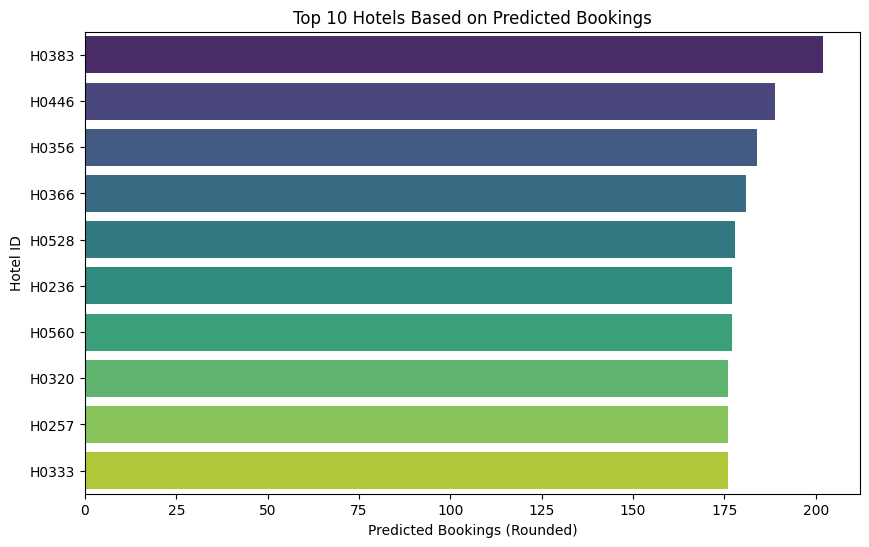

In [15]:
# Create a DataFrame for predictions with Hotel_ID and Predicted_Bookings
last_predictions = pd.DataFrame({'Hotel_ID': df['Hotel_ID'].iloc[X_test.index], 'Predicted_Bookings': y_pred_best})

# Visualize the top 10 hotels based on predicted bookings
visualize_top_10_hotels(last_predictions)
